Classification Report (Original Threshold):
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       247
           1       0.52      0.23      0.32        47

    accuracy                           0.84       294
   macro avg       0.70      0.60      0.62       294
weighted avg       0.81      0.84      0.82       294

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       247
           1       0.16      1.00      0.28        47

    accuracy                           0.16       294
   macro avg       0.58      0.50      0.14       294
weighted avg       0.87      0.16      0.05       294



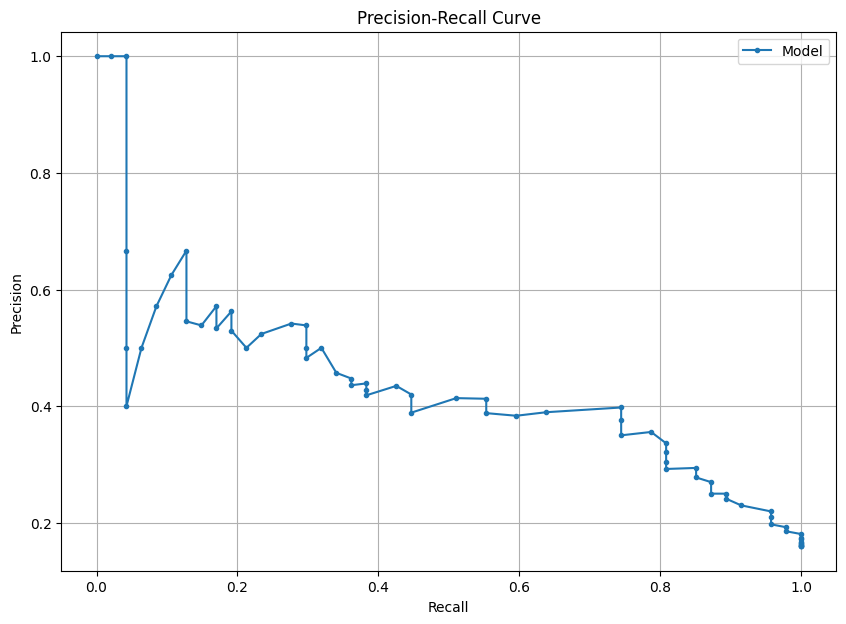

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('HR_DS.csv')

# Encode categorical variables
le = LabelEncoder()
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].apply(lambda col: le.fit_transform(col))
data['Attrition'] = le.fit_transform(data['Attrition'])

# Split the data
X = data.drop('Attrition', axis=1)
y = data['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling Techniques
# Option 1: SMOTE + RandomUnderSampler
resample_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))])

# Option 2: Cost-Sensitive Learning
# Uncomment the following lines to use cost-sensitive learning
#clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Option 3: XGBoost with scale_pos_weight
# Uncomment the following lines to use XGBoost
#xgb_clf = xgb.XGBClassifier(scale_pos_weight=sum(y_train==0) / sum(y_train==1), random_state=42)

# Fit the model (choose one of the options above)
resample_pipeline.fit(X_train_scaled, y_train)

# Predictions
y_pred = resample_pipeline.predict(X_test_scaled)

# Threshold Adjustment
y_probs = resample_pipeline.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
threshold_optimal = thresholds[recall.argmax()]
y_pred_adjusted = (y_probs > threshold_optimal).astype(int)

# Evaluation
print(f'Classification Report (Original Threshold):\n{classification_report(y_test, y_pred)}')
print(f'Classification Report (Adjusted Threshold):\n{classification_report(y_test, y_pred_adjusted)}')

# Precision-Recall Curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.', label='Model')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Hyperparameter Tuning (if needed)
# Uncomment the following lines to perform hyperparameter tuning
param_grid = {
     'n_estimators': [50, 100, 200],
     'max_depth': [None, 10, 20, 30],
     'class_weight': ['balanced', None]
 }
grid_search = GridSearchCV(estimator=resample_pipeline.named_steps['classifier'], param_grid=param_grid, scoring='recall', cv=5)
grid_search.fit(X_train_scaled, y_train)
best_clf = grid_search.best_estimator_

In [21]:
# Example: Custom Threshold
threshold_custom = 0.08  # Adjust this value
y_pred_custom = (y_probs > threshold_custom).astype(int)
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       1.00      0.14      0.24       247
           1       0.18      1.00      0.31        47

    accuracy                           0.28       294
   macro avg       0.59      0.57      0.27       294
weighted avg       0.87      0.28      0.25       294

